# IMPORTING PACKAGES

### support libraries

In [2]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
from PIL import Image
import PIL
import random
import numpy as np
from matplotlib.pyplot import imshow
import pandas as pd
from IPython.display import FileLink
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2
import time
import glob
import os
from tqdm import tqdm

ImportError: DLL load failed while importing cv2: The specified module could not be found.

### Deep Learning APIs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from tensorflow.python.keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras
import tensorflow.python.keras.backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.applications.vgg16 import VGG16

# IMPORTING DATA

In [3]:
# importing data from the csv
dataset = pd.read_csv('input_training/driver_imgs_list.csv')

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
# seperating date by driver
by_drivers=dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
# printing unique drivers
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [5]:
# number of classes
NUMBER_CLASSES = 10

### Get cv2 image

In [6]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
        description: To import image in an array
        
        input: 1. Path - path of the image to be extracted
               2. img_rows - width of the image after extraction
               3. img_cols - height of the image after extraction
               4. color_type - color scheme corresponding to opencv for extraction
            
        output: 1. The image in list format
    """
    # If the user want the image to be in grayscale
    if color_type == 1:
        # command for getting the image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # if the user want the image to be in rgb
    elif color_type == 3:
        # command for getting the image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # resizing the image according to the arguments
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

### Load training data

In [7]:
def load_train(img_rows, img_cols, color_type=3):
    """
        description: Loading the training dataset
        
        input: 1. img_rows - width of the image after extraction
               2. img_cols - height of the image after extraction
               3. color_type - color scheme corresponding to opencv for extraction
            
        output: 1. Array of all the training iamges
                2. Label for the corresponging training image in the training dataset
    """
    # To keep track of how long it takes to import
    start_time = time.time()
    # To sotre the training images
    train_images = []
    # To store the lables for training images
    train_labels = []
    # for each class
    for classed in tqdm(range(NUMBER_CLASSES)):
        # Printing the class name(folder name)
        print('Loading directory c{}'.format(classed))
        # All the files(images) inside each folder(corresponding to each class)
        files = glob.glob(os.path.join('input_training', 'train', 'c' + str(classed), '*.jpg'))
        # looping over all files
        for file in files:
            # importing using the above function
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            # appending the imported img into the train_images
            train_images.append(img)
            # appending the class for each image in teh train_images
            train_labels.append(classed)
    # Total time taken to complete
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels

### Normalizing and preprocessing training data

In [8]:
def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
        description: Normalizing the train data, splitting and getting it ready for training
                     One-hot encoding of labels
        
        input: 1. img_rows - width of the image after extraction
               2. img_cols - height of the image after extraction
               3. color_type - color scheme corresponding to opencv for extraction
            
        output: 1. x_train
                2. x_test
                3. y_train
                4. y_test
    """
    # Loading all the training data into X and labels
    X, labels = load_train(img_rows, img_cols, color_type)
    # Encoding labels into one-hot
    y = np_utils.to_categorical(labels, 10)
    # Splitting into training and testing data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Formatting as input for the Network
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

### Loading Testing data

In [9]:
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
        description: Importing the data for testing
        
        input: 1. size = Maximum number of testing images
               2. img_rows - width of the image after extraction
               3. img_cols - height of the image after extraction
               4. color_type - color scheme corresponding to opencv for extraction
            
        output: 1. x_test
                2. corresponding label to the above test set
    """
    # Path
    path = os.path.join('input_training', 'test', '*.jpg')
    # All the files inside the path
    files = sorted(glob.glob(path))
    # Initiating X_test and X_test_id for storing the images and corresponding labels
    X_test, X_test_id = [], []
    # Keeping count of total number of images
    total = 0
    # Number of files in the path
    files_size = len(files)
    # Looping over all the files
    for file in tqdm(files):
        # If total is greater than the max number of files
        if total >= size or total >= files_size:
            break
        # File name
        file_base = os.path.basename(file)
        # Getting the image in an array
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        # Appending it to the X_test
        X_test.append(img)
        # Appending the corresponding label
        X_test_id.append(file_base)
        # Increment total by 1
        total += 1
    return X_test, X_test_id

### Normalizing and preprocessing testing data

In [1]:
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    """
        description: Normalizing the test data, splitting and getting it ready for training
        
        input: 1. size - max number of images allowed to be extracted
               2. img_rows - width of the image after extraction
               3. img_cols - height of the image after extraction
               4. color_type - color scheme corresponding to opencv for extraction
            
        output: 1. x_test
                2. corresponding classes
    """
    # Get test_data and test_id
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    # Changing the data type to uint8
    test_data = np.array(test_data, dtype=np.uint8)
    # Reshaping to given size
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

### Defining data size

In [11]:
# Defining the specifications of the image to better fit the model
img_rows = 224
img_cols = 224
color_type = 3

## Running the functions

In [12]:
# Getting x_train, y_train, x_test, y_test
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|████████▎                                                                          | 1/10 [00:29<04:25, 29.45s/it]

Loading directory c1


 20%|████████████████▌                                                                  | 2/10 [00:52<03:40, 27.50s/it]

Loading directory c2


 30%|████████████████████████▉                                                          | 3/10 [01:15<03:04, 26.29s/it]

Loading directory c3


 40%|█████████████████████████████████▏                                                 | 4/10 [01:39<02:33, 25.64s/it]

Loading directory c4


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:03<02:05, 25.12s/it]

Loading directory c5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:29<01:41, 25.30s/it]

Loading directory c6


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:55<01:16, 25.37s/it]

Loading directory c7


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:16<00:48, 24.15s/it]

Loading directory c8


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:36<00:23, 23.00s/it]

Loading directory c9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:59<00:00, 23.96s/it]


Data Loaded in 239.6106128692627 second
Train shape: (17939, 224, 224, 3)
17939 train samples


In [13]:
# number of test samples we decide to check teh accuracy of the model
nb_test_samples = 200
# Getting test_files and the corresponding labels
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|▏                                                                             | 197/79726 [00:04<31:14, 42.43it/s]


Test shape: (200, 224, 224, 3)
200 Test samples


## Data Summary

In [14]:
# Name of classes
names = [item[17:19] for item in sorted(glob.glob("input/train/*/"))]
names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
# Number of files for testing
test_files_size = len(np.array(glob.glob(os.path.join('input_training', 'test', '*.jpg'))))
# Number of images for training
x_train_size = len(x_train)
# Number of classes
categories_size = len(names)
# Number of validation images
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


In [15]:
# Class mapped with name of class
activity_map = {'c0': 'Safe driving', 
                'c1': 'Right - Texting', 
                'c2': 'Right - Talking on the phone', 
                'c3': 'Left - Texting', 
                'c4': 'Left - Talking on the phone', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

# MODELING

### Defining Hyperparameters

In [17]:
# Hyperparameters
batch_size = 40
nb_epoch = 10

In [18]:
!rd -f saved_models/weights_best_vanilla.hdf5

Invalid switch - "weights_best_vanilla.hdf5".


### Callbacks

In [19]:
# Save model to
models_dir = "saved_models"
# Make directory if there is no directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
# Checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
# Callbacks
callbacks = [checkpointer, es]

### Model Architecture

In [20]:
def create_model_v1():
    """
        description: Defining the Model with keras backend
            
        output: 1. The Model
    """
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(img_rows, img_cols, color_type), kernel_size=(11,11),strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

In [21]:
def get_f1(y_true, y_pred): #taken from old keras source code
    """
        description: F1 value for accuracy
        
        input:  1. Real y to compare from
                2. Predicted y to check accuracy from
        
        output: 1. The F1 value
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Model Summary

In [22]:
# Create model
model_v1 = create_model_v1()
# Model.summary from keras
model_v1.summary()
# Settign optimizer, loss and metrics for the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
__

### Training step

In [23]:
# Training
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17920/17939 [============================>.] - ETA: 49:51 - loss: 3.0450 - acc: 0.12 - ETA: 25:28 - loss: 3.1902 - acc: 0.11 - ETA: 17:18 - loss: 3.9173 - acc: 0.09 - ETA: 13:13 - loss: 4.2495 - acc: 0.08 - ETA: 10:46 - loss: 4.4389 - acc: 0.09 - ETA: 9:08 - loss: 4.5056 - acc: 0.1000 - ETA: 7:58 - loss: 4.4764 - acc: 0.117 - ETA: 7:05 - loss: 4.5680 - acc: 0.121 - ETA: 6:24 - loss: 4.4945 - acc: 0.130 - ETA: 5:52 - loss: 4.4229 - acc: 0.132 - ETA: 5:25 - loss: 4.3146 - acc: 0.134 - ETA: 5:03 - loss: 4.2375 - acc: 0.135 - ETA: 4:44 - loss: 4.1477 - acc: 0.134 - ETA: 4:28 - loss: 4.0983 - acc: 0.133 - ETA: 4:14 - loss: 4.0058 - acc: 0.145 - ETA: 4:02 - loss: 3.9234 - acc: 0.154 - ETA: 3:52 - loss: 3.9244 - acc: 0.154 - ETA: 3:43 - loss: 3.8494 - acc: 0.159 - ETA: 3:34 - loss: 3.8033 - acc: 0.165 - ETA: 3:26 - loss: 3.7913 - acc: 0.161 - ETA: 3:20 - loss: 3.7586 - acc: 0.163 - ETA: 3:13 - loss: 3.7371 - acc: 0.160 - ETA: 3:07 - 

In [24]:
# Load weights from previouslt trained models
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

# MODEL EVALUATION

In [25]:
def plot_train_history(history):
    """
        description: Model Evaluation
        
        input: 1. Weigths after fitting the model
        
        output: 1. Accuray and loss over validation set
    """
    # Plotting acc form keras
    plt.plot(history.history['acc'])
    # Plotting val_acc from keras
    plt.plot(history.history['val_acc'])
    # Title of the plot
    plt.title('Model accuracy')
    # ylabel for the plot
    plt.ylabel('accuracy')
    # Xlabel for the plot
    plt.xlabel('epoch')
    # Legends for the plot
    plt.legend(['train', 'test'], loc='upper left')
    # Command to display the plot
    plt.show()

    # Plotting the loss from keras
    plt.plot(history.history['loss'])
    # Plotting the val_loss from keras
    plt.plot(history.history['val_loss'])
    # Title of the plot
    plt.title('Model loss')
    # ylabel for the plot
    plt.ylabel('loss')
    # Xlabel for the plot
    plt.xlabel('epoch')
    # Legends for the plot
    plt.legend(['train', 'test'], loc='upper left')
    # Command to display the plot
    plt.show()

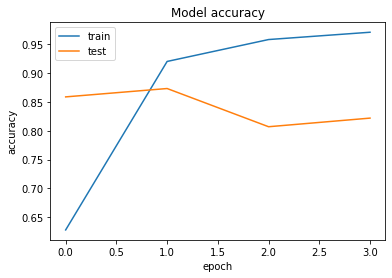

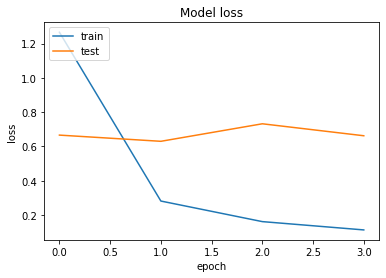

In [27]:
plot_train_history(history_v1)

In [28]:
# Scoring the model with the test set
score = model_v1.evaluate(x_test, y_test, batch_size=32)

4485/4485 [==============================] - ETA: 39s - loss: 0.1356 - acc: 0.93 - ETA: 17s - loss: 0.2800 - acc: 0.91 - ETA: 14s - loss: 0.2601 - acc: 0.91 - ETA: 11s - loss: 0.4735 - acc: 0.89 - ETA: 10s - loss: 0.5274 - acc: 0.87 - ETA: 9s - loss: 0.5440 - acc: 0.8785 - ETA: 9s - loss: 0.5316 - acc: 0.878 - ETA: 9s - loss: 0.5213 - acc: 0.880 - ETA: 8s - loss: 0.5006 - acc: 0.888 - ETA: 8s - loss: 0.5413 - acc: 0.888 - ETA: 8s - loss: 0.5160 - acc: 0.893 - ETA: 8s - loss: 0.4920 - acc: 0.896 - ETA: 7s - loss: 0.5128 - acc: 0.890 - ETA: 7s - loss: 0.5426 - acc: 0.887 - ETA: 7s - loss: 0.5276 - acc: 0.887 - ETA: 6s - loss: 0.5269 - acc: 0.885 - ETA: 6s - loss: 0.5478 - acc: 0.885 - ETA: 6s - loss: 0.5423 - acc: 0.885 - ETA: 6s - loss: 0.5551 - acc: 0.885 - ETA: 6s - loss: 0.5489 - acc: 0.886 - ETA: 6s - loss: 0.5477 - acc: 0.887 - ETA: 6s - loss: 0.5363 - acc: 0.889 - ETA: 6s - loss: 0.5227 - acc: 0.892 - ETA: 6s - loss: 0.5329 - acc: 0.892 - ETA: 6s - loss: 0.5293 - acc: 0.893 - ETA:

### Accuracy and Loss

In [29]:
# Printing Loss and Accuracy
print('Loss     = ' ,score[0])
print('Accuracy = ' ,score[1])

Loss     =  0.6300856571166943
Accuracy =  0.87313265


# Single Input

1/1 [==============================] - 0s 8ms/sample
Left - Talking on the phone


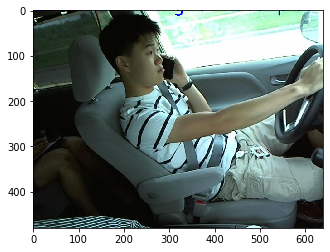

In [56]:
def plot_test_classs(model, manual_imgs, image_number, color_type=3):
     """
        description: Predicting from raw input after preprocessing to the corresponding model
        
        input:  1. Model
                2. Images to be predicted
                3. Index of image from the set of Images
                4. Color type of the image
        
        output: 1. Prediction
    """
    # Selecting a specific image from the set of images sent for prediction
    img_brute = manual_imgs[image_number]
    # Resizing it to fit the model
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    # Showing the image
    plt.imshow(img_brute, cmap='gray')
    
    # Resing it to fit the model
    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
    # Prediction
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    # Mapping prediction with activity map
    predicted_text = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    
    # Getting image to write over
    img_dis = get_cv2_image(manual_pics[image_number],640,480)
    # Changing color code from BGR to RGB
    img_dis = cv2.cvtColor(img_dis, cv2.COLOR_BGR2RGB)
    # Showing the image
    plt.imshow(img_dis)
    cv2.imshow('test',img_dis)
    # Writing the prediction over the image
    write_img(image_number, predicted_text)
    # Printing the predicted text
    print(predicted_text)
    
plot_test_classs(model_v1, manual_imgs, 0)

# Video !!!!!

### Capturing framewise

In [42]:
def write_img(image_number, text):
    """
        description: Writing the given text over a picture
        
        input:  1. Index of the image
                2. Text
        
        output: 1. The image after writing over it
    """
    # Spacial position of the text
    org = (30,450)
    # Font scale
    fontscale = 1.5
    # Color of the text
    color = (255,0,0)
    # Thickness of the font
    thickness=2
    # Font
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # PutText command form openCV
    imagee = cv2.putText(manual_displays[image_number], text, org, font,  
                       fontscale, color, thickness, cv2.LINE_AA)
    # Changing color from BGR to RGB
    imagee = cv2.cvtColor(imagee, cv2.COLOR_BGR2RGB)
    # Showing the image
    plt.imshow(imagee)
    cv2.imshow('test',imagee)
    return imagee


def import_images(path = 'prediction/input/framewise/*.jpg'):
    # Path where the image is stored
    path = 'C:\\Users\\revan\\JUPYTERRRRRRRRRRRRRRRRRR\\Iris\\Drowsiness\\input_training\\train\\c4\\img_803.jpg'
    
    manual_pics = glob.glob(path)
    
    manual_imgs = []
    # Array for storing all the raw pictures
    manual_displays = []
    
    for file in manual_pics:    
        
        manual_display = get_cv2_image(file,640,480)
       
        manual_displays.append(manual_display)
        # For prediction
        manual = get_cv2_image(file, img_rows=224, img_cols=224, color_type=3)
        # For flipping the image
        #manual = img_flip_lr = cv2.flip(manual, 1)
        # Appending prediction image into manual_imgs
        manual_imgs.append(manual)

    # Changing into uint8
    manual_imgs = np.array(manual_imgs, dtype=np.uint8)
    # Changing into uint8
    manual_imgs = manual_imgs.reshape(-1,img_rows,img_cols,3)
    
    
    
    # Path where the image is stored
    path = 'prediction/input/framewise/*.jpg'
    j = 0
    # Set of all pixtures in the path
    manual_pics = sorted(glob.glob(path), key=os.path.getmtime)
    # Array for storing all the pictures after preprocessing
    manual_imgs = []
    # Array for storing all the raw pictures
    manual_displays = []
    # Looping over all pictures in the path
    for file in manual_pics:
        # For displayingn the picture and writing over it
        manual_display = get_cv2_image(file,640,480)
        # For flipping the image
        # manual_display = img_flip_lr = cv2.flip(manual_display, 1)
        # Appending display image into manual_display
        manual_displays.append(manual_display)
        manual = get_cv2_image(file, img_rows=224, img_cols=224, color_type=3)

        manual_imgs.append(manual)
        j += 1

    manual_imgs = np.array(manual_imgs, dtype=np.uint8)
    manual_imgs = manual_imgs.reshape(-1,img_rows,img_cols,3)
    return manual_imgs, manual_displays

In [30]:
def plot_test_classs(model, manual_imgs, image_number, color_type=3):
    img_brute = manual_imgs[image_number]
    img_brute = cv2.resize(img_brute,(224,224))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,224,224,3)
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    predicted_text = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    
    #displaying picture
    editted = write_img(image_number, predicted_text)
    write_img(image_number, predicted_text)
    editted = cv2.cvtColor(editted, cv2.COLOR_BGR2RGB)
    name = i
    cv2.imwrite('prediction/output/images/%s.jpg' %name, editted)

In [31]:
def get_video():
    video = cv2.VideoCapture('prediction/input/project.mp4');

    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

    if int(major_ver)  < 3 :
        fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    else :
        fps = video.get(cv2.CAP_PROP_FPS)

    img_array = []
    for filename in sorted(glob.glob('prediction/output/images/*.jpg'), key=os.path.getmtime):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        img_array.append(img)
    size = (width,height)

    out = cv2.VideoWriter('prediction/output/Video/outfvput.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 1, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [42]:
FrameCapture('prediction/input/VID20200504144113-1.mp4')

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


1/1 [==============================] - 0s 7ms/sample


IndexError: list index out of range

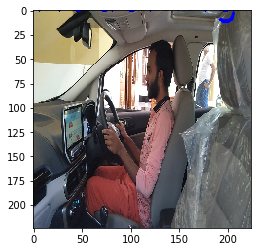

In [43]:
list = os.listdir("C:\\Users\\revan\\JUPYTERRRRRRRRRRRRRRRRRR\\Iris\Drowsiness\\prediction\\input\\framewise")
number_files = len(list)
for i in range(number_files):
    plot_test_classs(model_v1, manual_imgs, i)

get_video()